# Dog Breed Identification
## Farhad Navid 

The goal of this analysis is to identify the various breed of dogs using Dog images provided in kaggle data set. 

This document is intended to go through the entire process step by step and at each step talk about the challenges faced during this project. 
**Files:**
 * **DB_EDA.jpynb** =========>This file performs the normal EDA type analysis on the data set.
 * **Data_Prep.jpynb** ========>This file does the data preparation for the analysis including the augmentation. 
 * **Models.jpynb** ==========>This file contains the models we will use.
 * **Transfer_Learning.jpynb**==>This file contains the Transfer learning with Augmented images.
 * **Transfer_Learning_org.jpynb**=>This file is TF with original training set (no Augmentation)
 * **ReadMe.txt** ============>The read me file for the repository. 
 * **Licenses** ==============>The license file
 * **Document.jpynb** ========>This document has instruction on creating AWS instance and loading up the files and datasets to AWS EBS system. please note these are some points I came across and I hope you find it helpful.
Following section is the step by step instruction    

**Steps:**
1. Initiate AWS E2 instance to run this project.
 * Upload the data files.
 * Unzip the data files.
 * Upload the jupyter notebook files. 
2. EDA, Examine some basic characteristic of the dataset, Histogram, file structure, dim, ...
3. Preprocess the images. **resize and reshape** i.e. All the picture having the same dimension. 
4. Create training data set X_train, y_train, Xtrain will have the images and Y_train will have the lable. 
6. Augment the data.  Need to add more images to the data set. 
 * Pick random number of images  
 * Create 5X per image.  Rotate, Flip, color, shift, 
 * reshuffle the training data set
 * add the newly created images to the training set directory.
 * recreate the X_train and y_train NumPy array.
7. Create the X_test dataset this is test data set.
8. Prepare data to fit into a deep learning model Create a 20, 80 splits for train and validate data set. 
9. Build Model (Few Models are considered)
 * Simple CNN (Convolutional Neural Network)
 * Sequential CNN VGG style with 2 VGG block inception module architecture
 * Functional API CNN with inception architecture using BatchNormalization and Dropout
 * Use the Keras pretrained model. (VGG19)
 
The Model will be used to run the test data and record the validation.
A commentary for each step will be provided along with some visualization and summary through the process.  
in conclusion a summary commentary will be provided to discuss the challenges, weaknesses and opportunities for improvement in the models or the process.




In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy 
import PIL
import pandas as pd
import os
import glob
import time
import numpy as np
import h5py

import shutil

import seaborn as sns
import missingno as msno

from tqdm import tqdm

from keras.preprocessing import image

from subprocess import check_output

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

%matplotlib inline
K.set_image_dim_ordering( 'tf' )

Using TensorFlow backend.


This next block of code does represent the Directory structure of the data once the repository was selected.  In this instance the [**AWS**](https://www.AWS.amazon.com/) (paid service) were utilized.  

In [2]:
# directory structure of the data

dpath_train = '/home/ubuntu/train'      # Data path to training data set
dpath_test  = '/home/ubuntu/test'       # Data path to test data set
dpath       = '/home/ubuntu'
label_f     = '/home/ubuntu/labels.csv' # Path to the label file 

## Visualizing the image.

* ** Examining the labels for the data set.**
* ** Looking at one of the files to get an idea about the pictures.**

In [3]:
labels = pd.read_csv(label_f)
labels.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [4]:
labels.tail(10)

,id,breed
10212,ffc532991d3cd7880d27a449ed1c4770,tibetan_terrier
10213,ffca1c97cea5fada05b8646998a5b788,english_foxhound
10214,ffcb610e811817766085054616551f9c,briard
10215,ffcde16e7da0872c357fbc7e2168c05f,airedale
10216,ffcffab7e4beef9a9b8076ef2ca51909,samoyed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


## Checking the images
* ** Train data set images**
 * Original image and resized image
* ** Test Data set images**
 * Original image and resized image

(375, 500, 3)


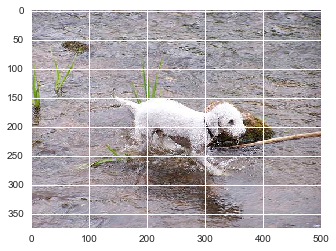

In [5]:
# sample image for debug purpose I will eliminate once sure the data set is correct. 
# Playing with the image and ploting will be use to compare with reduced size image.
os.chdir(dpath_train)
dogs = sorted(glob.glob('*.jpg'))
c5 = PIL.Image.open(dogs[5]) #read file path to an image, now c0 is a numpy image
cc5=np.array(c5)
print(cc5.shape)  # cc0 is the numpy array
plt.imshow(c5)    # vplotting the origenal sample image 

* **Now let’s look at the image when we resize it.  need to make sure the image looks ok.**

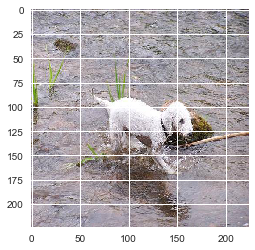

In [6]:
#cr0 is the reduced version of same image as above AKA resizeing the picture
cr5=c5.resize((224,224))
plt.imshow(cr5)    #the dog looks squashed, but seems ok and features are still there.  

## Checking the test images 
### Just print a sample make sure it looks ok for comparison.

10357


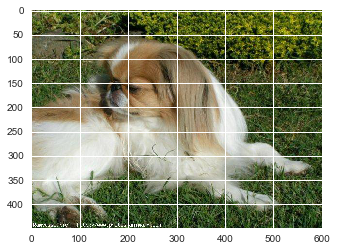

In [7]:
# now let's gt the test data prepared.
os.chdir(dpath_test)    # need to be in test data dir
# these are the files in the train directory
test_dogs = sorted(glob.glob('*.jpg'))
# chk to see the num of files in directory  can be eliminated once it is working
print(len(test_dogs))
c0_test = PIL.Image.open(test_dogs[0])
#test_dogs[:10]
plt.imshow(c0_test) # visualize a smaple image

* **Resized test image**

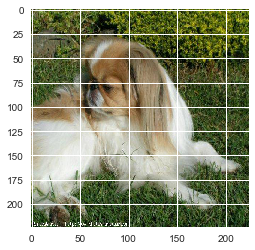

In [8]:
# Plot the resized just to make sure still looks OK.
cr0_test=c0_test.resize((224,224))
plt.imshow(cr0_test) #now the dogt looks squashed, but seems ok for this one. 

## Histogram of the Data set

/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


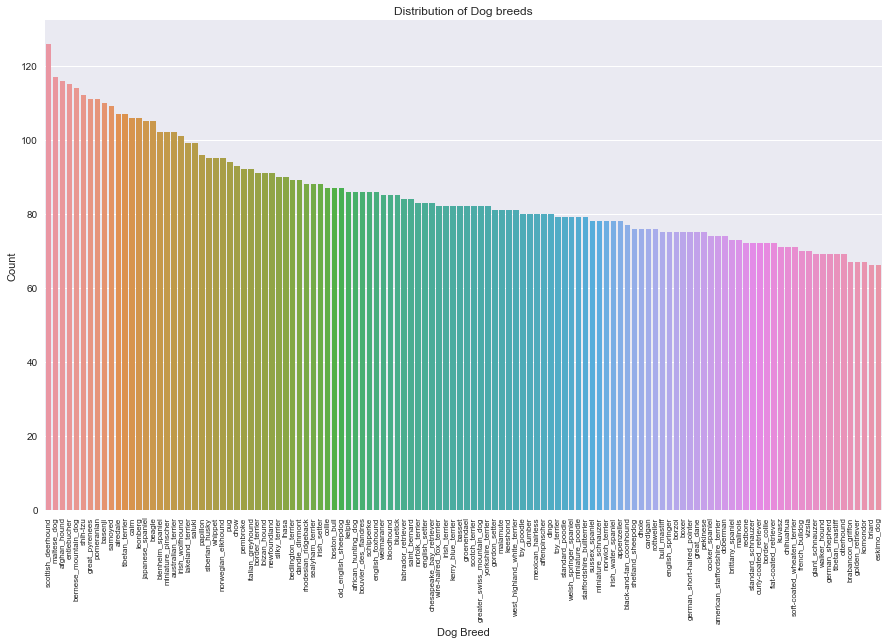

In [9]:
yy = pd.value_counts(labels['breed'])

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of Dog breeds')

** We will examin the Counts for top 5 catagories and 5 Lowest counts in the data set** 

In [10]:
yy.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
yy.tail()

brabancon_griffon    67
golden_retriever     67
komondor             67
briard               66
eskimo_dog           66
Name: breed, dtype: int64

Making sure the pictures have all the necessary features when resized to 224 X 224 image size.

# Legacy code just for history
## Models  
**Note:** 
* The BatchNormalization and Dropouts are attempted to be used in all models to make sure they all have same level playing field for comparison.  
* #### First Model is a 4 convolution CNN 
* #### Second is another Sequential model (VGG style)
* #### Third model is Functional API model with inception layer

### Directory structure
* This section can be used to create directory structure for each Breed in the data set. I left it here just in case if someone needed this code. or future usage.

I did not used it because decided to Augment all the images instead of augmenting by breed.  
 

In [23]:

path = "/home/ubuntu/"

label = pd.read_csv(path + "labels.csv")
train_path = '/home/ubuntu/train/'
new_train_path = '/home/ubuntu/new_train/'
#--- snippet to split train images into 120 folders ---

c = 0
for i in range(len(label)):
    l = label.id[i]
    for filename in os.listdir(train_path):	    
        f = filename[:-4]
        if (l == f):
            print (c)
            c+=1
            if not os.path.exists(new_train_path + label.breed[i]):
                os.makedirs(new_train_path + label.breed[i])
                shutil.copy2(train_path + filename, new_train_path + label.breed[i])				
            else:
                shutil.copy2(train_path + filename, new_train_path + label.breed[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075


3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715


5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373


6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019


8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672


10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221


In [28]:
from keras.models import Sequential
# 4 Convolution layer CNN network
model_1 = Sequential()

model_1.add(Conv2D(32, 3 , padding='same',input_shape=(im_W, im_H, 3)))
model_1.add(BatchNormalization(axis=3, scale=False))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model_1.add(Dropout(0.2))

#model_1.add(Conv2D(32, 3, padding='same'))
#model_1.add(BatchNormalization(axis=3, scale=False))
#model_1.add(Activation("relu"))
#model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
#model_1.add(Dropout(0.2))

model_1.add(Conv2D(64, 3, padding='same'))
model_1.add(BatchNormalization(axis=3, scale=False))
model_1.add(Activation("relu"))
model_1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model_1.add(Dropout(0.2))

model_1.add(Conv2D(128, 3, padding='same'))
model_1.add(BatchNormalization(axis=3, scale=False))
model_1.add(Activation("relu"))
model_1.add(Flatten())
model_1.add(Dropout(0.5))

model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(120, activation='softmax'))
model_1.summary()

adam = Adam(lr=0.001)
model_1.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log_file = model_1.fit(X_train, y_train, validation_split=0.2, epochs= 20, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final predict the test files of the model
prediction_1 = model_1.predict(X_test)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log_file.history['acc'],'b') 
plt.plot(log_file.history['val_acc'],'r')
plt.show()

TypeError: softmax() got an unexpected keyword argument 'axis'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
batch_normalization_31 (Batc (None, 98, 98, 64)        256       
_________________________________________________________________
activation_64 (Activation)   (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_32 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
activation_65 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 48, 48, 64)        0         
__________

1826.1456282138824  seconds


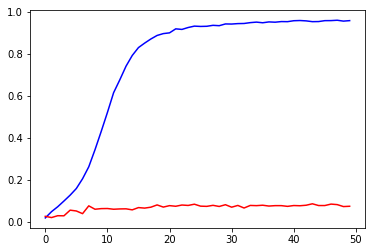

In [35]:
# Create a model with 4 convolutional layers (2 repeating VGG stype units) and 2 dense layers before the output
# Use Batch Normalization for every conv and dense layers and Droupout 

def model():
    model = Sequential()
    model.add(Conv2D(64, 3, input_shape=(im_W, im_H, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(120))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    return model

model_2 = model()
model_2.summary()
adam = Adam(lr=0.005)
model_2.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log_file = model_2.fit(X_train, y_train, validation_split=0.2, epochs= 50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final predict the test files of the model
prediction_2 = model_2.predict(X_test)

plt.plot(log_file.history['acc'],'b') 
plt.plot(log_file.history['val_acc'],'r')
plt.show()

In [15]:
# Inception layer with batchnormalization from our previous work, should have a better response. 
def inceptionWBN(x, n = 32):
    t1 = Conv2D(n, 1, padding='same')(x)  # first Tower a 1X1 Conv
    t1 = BatchNormalization()(t1)
    t1 = Activation('relu')(t1)
    t2 = Conv2D(n, 1, padding='same')(x)  # second Tower a 1X1 followed by 3X3 conv
    t2 = BatchNormalization()(t2)
    t2 = Activation('relu')(t2)
    t2 = Conv2D(n, 3, padding='same')(t2)
    t2 = BatchNormalization()(t2)
    t2 = Activation('relu')(t2)    
    t3 = Conv2D(n, 1, padding='same')(x)  # third Tower a 1X1 Followed by 5X5 vonv
    t3 = BatchNormalization()(t3)
    t3 = Activation('relu')(t3)    
    t3 = Conv2D(n, 5, padding='same')(t3)
    t3 = BatchNormalization()(t3)
    t3 = Activation('relu')(t3)  
    t4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x) # fourth Tower MaxPool 3X3 Followed by 1X1 conv   
    t4 = Conv2D(n, 1, padding='same')(t4)
    t4 = BatchNormalization()(t4)
    t4 = Activation('relu')(t4)     

    conc =  Concatenate(axis=-1)([t1,t2,t3,t4])  # Input to the next layer
    return conc

In [16]:
# I will be using the Functional API with 3 inception layer followed by a dense layer for the training.  
def model():
    inputs = Input(X_train.shape[1:])
    inp1 = inceptionWBN(inputs)
    mp1 = MaxPooling2D((2,2))(inp1)
    inp2 = inceptionWBN(mp1)
    mp2 = MaxPooling2D((2,2))(inp2) 
#    inp3 = inceptionWBN(mp1)
#    mp3 = MaxPooling2D((2,2))(inp3) 
    fltn = Flatten()(mp2)
    dns = Dense(256)(fltn) #. start with 64 and go up from there
    dns = BatchNormalization()(dns)
    dns = Activation('relu')(dns)
    out = Dense(120, activation='softmax')(dns)
    model = Model(inputs, out)
    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 100, 100, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 100, 100, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 100, 100, 32) 128         conv2d_56[0][0]                  
__________________________________________________________________________________________________
batch_norm

Train on 8177 samples, validate on 2045 samples
Epoch 1/20
 - 49s - loss: 4.7580 - acc: 0.0303 - val_loss: 5.4773 - val_acc: 0.0323
Epoch 2/20
 - 45s - loss: 4.0141 - acc: 0.0989 - val_loss: 4.4882 - val_acc: 0.0513
Epoch 3/20
 - 45s - loss: 3.4570 - acc: 0.1914 - val_loss: 4.5730 - val_acc: 0.0704
Epoch 4/20
 - 45s - loss: 2.5224 - acc: 0.3902 - val_loss: 5.3008 - val_acc: 0.0655
Epoch 5/20
 - 45s - loss: 1.1130 - acc: 0.7373 - val_loss: 6.5909 - val_acc: 0.0557
Epoch 6/20
 - 45s - loss: 0.2463 - acc: 0.9570 - val_loss: 6.6572 - val_acc: 0.0509
Epoch 7/20
 - 45s - loss: 0.0424 - acc: 0.9974 - val_loss: 6.2435 - val_acc: 0.0660
Epoch 8/20
 - 45s - loss: 0.0168 - acc: 0.9990 - val_loss: 5.8801 - val_acc: 0.0773
Epoch 9/20
 - 45s - loss: 0.0124 - acc: 0.9991 - val_loss: 5.8125 - val_acc: 0.0880
Epoch 10/20
 - 45s - loss: 0.0101 - acc: 0.9993 - val_loss: 5.7119 - val_acc: 0.0866
Epoch 11/20
 - 45s - loss: 0.0105 - acc: 0.9993 - val_loss: 5.8481 - val_acc: 0.0934
Epoch 12/20
 - 45s - loss:

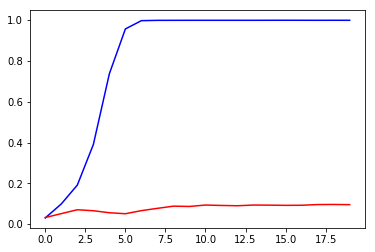

In [17]:
# Run the models to see the accuray
model_3 = model()
model_3.summary()
print(X_train.shape,y_train.shape,X_test.shape)
adam = Adam(lr=0.01)
model_3.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log_file = model_3.fit(X_train, y_train, validation_split=0.2, epochs= 20, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final predict the test files of the model
prediction_3 = model_3.predict(X_test)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

plt.plot(log_file.history['acc'],'b') 
plt.plot(log_file.history['val_acc'],'r')
plt.show()

In [19]:
prediction

array([[9.96303129e-07, 7.04222242e-04, 1.05334145e-07, ...,
        4.53925932e-05, 4.96713538e-03, 1.94656172e-06],
       [1.13428212e-06, 1.01241412e-05, 6.93005404e-08, ...,
        1.18420558e-05, 3.76698117e-05, 4.15600496e-08],
       [2.78639636e-04, 4.62540658e-03, 1.45980506e-04, ...,
        6.79078922e-02, 1.18075241e-05, 4.98616428e-04],
       ...,
       [6.56763499e-04, 1.52022069e-04, 6.72852993e-03, ...,
        5.63953677e-03, 9.45150589e-07, 3.23009491e-01],
       [9.61805381e-06, 1.36518327e-04, 7.82994448e-06, ...,
        6.01543070e-05, 7.29359017e-05, 7.31054926e-03],
       [3.65982078e-06, 9.89982300e-03, 1.77801601e-04, ...,
        1.10364403e-03, 8.50484967e-02, 4.62856769e-05]], dtype=float32)

## Creating the submission file in CSV format.

In [44]:
names = unique_Dog_Breed
rows = os.listdir(dpath +'/test')
os.chdir(dpath)
df = pd.DataFrame(prediction, index=rows, columns=names)
df.rename(columns={'index': 'img'}, inplace=True)
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
9d591f86fdd00f9731dc51d68c7b6323.jpg,9.963031e-07,0.000704,1.053341e-07,0.000019,0.001015,1.286621e-07,2.543344e-06,0.000025,0.000044,2.656787e-04,...,0.000103,3.336046e-05,1.932227e-04,5.487259e-05,0.000004,0.001167,0.000018,0.000045,0.004967,1.946562e-06
6893b5ed882c7ae791e4a440f613a3f8.jpg,1.134282e-06,0.000010,6.930054e-08,0.000011,0.000082,3.173161e-08,8.690272e-06,0.000005,0.000013,5.474954e-07,...,0.000016,1.628623e-02,2.513495e-08,2.664325e-07,0.000001,0.000009,0.215687,0.000012,0.000038,4.156005e-08
2a1c95b9f131236b715df75ff815fd0b.jpg,2.786396e-04,0.004625,1.459805e-04,0.190624,0.003584,6.062565e-06,5.005667e-05,0.001121,0.000025,5.829281e-02,...,0.000132,6.105131e-03,1.605699e-03,6.783912e-06,0.001254,0.000105,0.000554,0.067908,0.000012,4.986164e-04
87e96ca57ae92a499e057debb62fc232.jpg,2.514467e-04,0.022263,1.180193e-03,0.000277,0.000959,4.392076e-06,1.673603e-02,0.000406,0.001522,2.333737e-05,...,0.001356,2.002962e-07,5.311599e-03,2.912785e-02,0.003575,0.000334,0.000278,0.032978,0.000013,6.388185e-06
d2da98041804728e98d85b9ee42571a3.jpg,2.685920e-05,0.000365,2.741268e-05,0.000013,0.008109,2.180807e-03,7.114688e-07,0.000001,0.000009,4.383926e-05,...,0.000095,6.538648e-04,5.926685e-07,6.879187e-07,0.005938,0.000101,0.007391,0.000081,0.000131,2.716689e-05


### Display just to check.

In [38]:
df.to_csv('submission.csv', index=True, header=True, sep=',')

courses			 README.txt		    test.zip
examples		 sample_submission.csv.zip  train
Final_project_Dog.ipynb  submission.csv		    traindata.hdf5
labels.csv		 test			    train.zip
labels.csv.zip		 testdata.hdf5


## **Ending Notes:**
The interesting point of this particular project was training set data.  there were total of 10222 dogs in the taring directory and 120 unique dog species. the histogram of this data set showed and average of 100 dogs per breed category.  this is too small of data.  The 3 model utilized in here are the basic one CNN, one two segment VGG and the third one is functional API model with inception module.  The best validation accuracy was with functional API at about 10% very low. the result does indicate a major overfilling in these models.  
**Following are some ideas for reducing overfitting:**
* Add more data
 * This was not possible limited by data set.  
* Use data augmentation
 * This is the most promising way to help this problem which requieres abit more work to add to this data set. 
* Use architectures that generalize well
* Add regularization (i.e dropout)
 * Various dropout was utilized and the best one was picked for each model
* Reduce architecture complexity. 
 * tried removing some layers but not much help in here.
 
**I was able to increase the validation accuracy form couple of percent to about 18% the high-water mark. Next, I will try the input augmentation to see the improvement on the prediction.  This will require a bit of work.**  